In [55]:
import random
import matplotlib.pyplot as plt
import numpy as np
import u3
import time
import bitstring
from functools import reduce
from scipy.signal import butter, lfilter, lfilter_zi, freqz

d = u3.U3()
def setFIO(speed1, speed2):
    d.getFeedback(u3.Timer0Config(TimerMode = 0, Value = int((1-speed1)*65535)))
    d.getFeedback(u3.Timer1Config(TimerMode = 0, Value = int((1-speed2)*65535)))


In [3]:
def getData(frequency, size):
    MAX_REQUESTS = 10
    d.configIO(NumberOfTimersEnabled = 2, FIOAnalog = 4)
    d.configTimerClock(TimerClockBase = 7, TimerClockDivisor = 15)
    trueFrequency = frequency*150
    trueSize = size*8
    direction = 0
    numbers = np.array([])
    while numbers.size < trueSize:
        if direction == 0:
            setFIO(1, 0)
            direction = 1
        elif direction == 1:
            setFIO(0, 1)
            direction = 0
        k = 0
        while (k < trueFrequency and numbers.size < trueSize):
            a1 = d.getAIN(0)
            #a3 = d.getAIN(2)
            #a4 = d.getAIN(3)
            numbers = np.append(numbers, a1)
            #numbers.append(a3)
            #numbers.append(a4)
            k = k+1
            time.sleep(0.01)
        setFIO(0,0)
    
    
    return numbers


def encrypt(key, inputMethod = 1):
    # Read in the input file to be encrypted.
    if inputMethod == 0:
        with open('/Users/veronicabodenstein/Classes/input.txt', 'rb') as inputFile:
            rIn1 = inputFile.read()
        rIn = bytes(rIn1, 'utf-8')
    elif inputMethod == 1:
        rIn1 = input("What do you want to encrypt?")
        rIn = bytes(rIn1, 'utf-8')

    def byteArrayXOR(a1, a2):
        # Calculate the elementwise XOR and return the result as bytes.
        return bytes(map(lambda x, y: x^y, a1,a2))
            
    
    encrypted = byteArrayXOR(rIn, key)
    print(f'The input is: {rIn} \n')
    print(f'The key is: {bytes(key)} \n')
    print(f'The encrypted data is: {encrypted} \n')
    with open('output.txt', 'wb') as outputFile:
        outputFile.write(encrypted)
    decrypted = byteArrayXOR(encrypted,key).decode('UTF-8')
    print(f'The decrypted data is: {decrypted}')


In [4]:
def filterData(cutoff, numbers):

    diff = []
    for i in range(1, len(numbers)):
        value = numbers[i] - numbers[i - 1]
        diff.append(value)

    # Filter requirements.
    order = 6
    fs = 200       # sample rate, Hz

    b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)

    zi = lfilter_zi(b, a) * diff[0]

    y, _ = lfilter(b, a, diff, zi=zi)

    #ratio = []
    #nMean = np.mean(numbers)
    #nStd = np.std(numbers)
    #for n in np.arange(len(numbers)/5,1,-1):
    #    result = [np.mean(a) for a in np.array_split(numbers,n)]
    #    data = np.where(np.logical_or(result > nMean+0.2*nStd,result < nMean-0.2*nStd), 1, 0)
    #    ratio.append(sum(data)/len(data))
    return y[1000:], diff

In [29]:
def genRand(data,sigma):
    dStd = np.std(data)
    peaks = np.where(np.logical_or(data > sigma*dStd,0), 1, 0)
    prev = 0
    run = 0
    strings = []
    for i in np.arange(1,len(peaks)):
        if peaks[i] == prev:
            run += 1
        else:
            strings = np.append(strings,run)
            run = 0
        prev = peaks[i]
    bMed = np.median(strings)
    bits = np.where(strings > bMed, 1, 0)
    bits = bits[25:]
    bitStr = ''.join(str(bit) for bit in bits)
    encBytes = int(bitStr, 2).to_bytes((len(bitStr) + 7) // 8, byteorder='big')

    return peaks, strings, bits, encBytes

In [25]:
def takeFFT(data):
    ps = np.abs(np.fft.fft(data-np.mean(data)))
    freqs = np.fft.fftfreq(data.size, 1/100)
    idx = np.argsort(freqs)
    return ps, freqs, idx

In [40]:
numsOrdered = getData(0.25,2000)
time.sleep(5)
numsChaotic = getData(0.20,2000)

KeyboardInterrupt: 

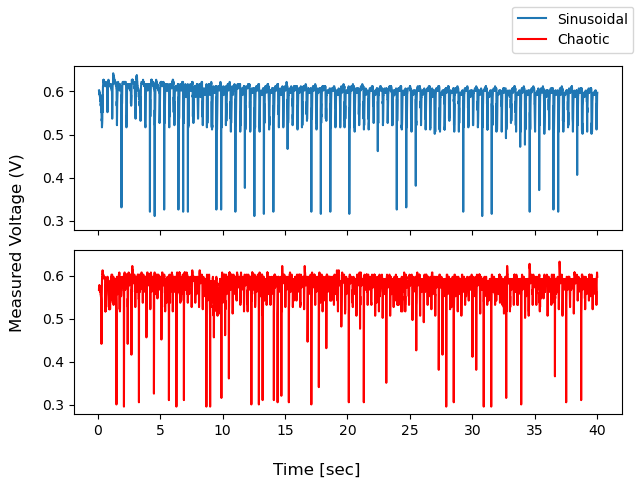

In [8]:
fig, axs = plt.subplots(2,1, sharex=True, sharey=True)
fig.supxlabel('Time [sec]')
fig.supylabel('Measured Voltage (V)')
axs[0].plot(np.arange(1,len(numsOrdered)+1)[10:]/100,numsOrdered[10:], label = 'Sinusoidal')
axs[1].plot(np.arange(1,len(numsChaotic)+1)[10:]/100,numsChaotic[10:], color = 'red', label = 'Chaotic')
fig.legend(loc=1)
fig.tight_layout(rect=[0, 0, 1, 0.9])

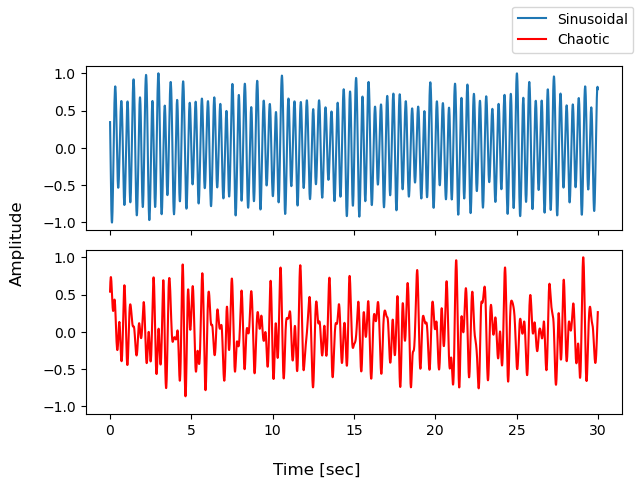

In [30]:
filts1, diffs1 = filterData(5, numsOrdered)
filts2, diffs2 = filterData(5, numsChaotic)

fig, axs = plt.subplots(2,1, sharex=True, sharey=True)
fig.supxlabel('Time [sec]')
fig.supylabel('Amplitude')
axs[0].plot(np.arange(1,len(filts1)+1)/100,filts1/(max(filts1)), label = 'Sinusoidal')
axs[1].plot(np.arange(1,len(filts2)+1)/100,filts2/(max(filts2)), color = 'red', label = 'Chaotic')
fig.legend(loc=1)
fig.tight_layout(rect=[0, 0, 1, 0.9])

[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
[0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0
 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1]
b'\x05UQUUUU\x11UUUQUUUUU'
b'\x11QQ\xd5TGGQE\xc5\xdd]'


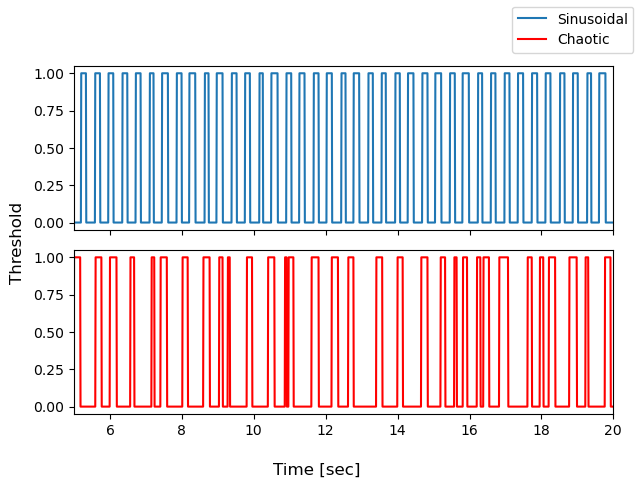

In [31]:
peaks1, strings1, bits1, data1 = genRand(filts1,0.5)
peaks2, strings2, bits2, data2 = genRand(filts2,0.5)
fig, axs = plt.subplots(2,1, sharex=True, sharey=True)
fig.supxlabel('Time [sec]')
fig.supylabel('Threshold')
axs[0].plot(np.arange(1,len(peaks1)+1)/100,peaks1, label = 'Sinusoidal')
axs[1].plot(np.arange(1,len(peaks2)+1)/100,peaks2, color = 'red', label = 'Chaotic')
axs[0].set_xlim(5,20)
fig.legend(loc=1)
fig.tight_layout(rect=[0, 0, 1, 0.9])
print(bits1)
print(bits2)
print(data1)
print(data2)

In [39]:
encrypt(data2)

The input is: b'Test!' 

The key is: b'\x11QQ\xd5TGGQE\xc5\xdd]' 

The encrypted data is: b'E4"\xa1u' 

The decrypted data is: Test!


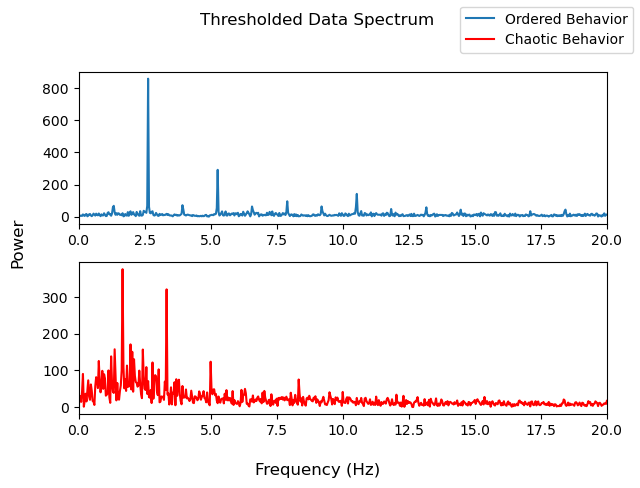

In [37]:
ps1, freqs1, idx1 = takeFFT(peaks1)
ps2, freqs2, idx2 = takeFFT(peaks2)

fig, axs = plt.subplots(2,1)
fig.supxlabel('Frequency (Hz)')
fig.supylabel('Power')
fig.suptitle('Thresholded Data Spectrum')
axs[0].plot(freqs1[idx1],ps1[idx1], label = 'Ordered Behavior')
axs[1].plot(freqs2[idx2],ps2[idx2], color = 'red', label = 'Chaotic Behavior')
axs[0].set_xlim(0,20)
axs[1].set_xlim(0,20)
fig.legend(loc=1)
fig.tight_layout(rect=[0, 0, 1, 0.95])

In [53]:
sinusoidal1 = getData(0.25,1000)
sinusoidal2 = getData(0.25,1000)
sinusoidal3 = getData(0.25,1000)
sinusoidal4 = getData(0.25,1000)
chaotic1 = getData(0.2,1000)
chaotic2 = getData(0.2,1000)
chaotic3 = getData(0.2,1000)
chaotic4 = getData(0.2,1000)

In [48]:
voltage4 = getData(0.25,1000)
time.sleep(10)
voltage5 = getData(0.25,1000)
time.sleep(10)
voltage6 = getData(0.25,1000)
time.sleep(10)
voltage7 = getData(0.25,1000)

KeyboardInterrupt: 

In [51]:
voltage8 = getData(0.25,1000)

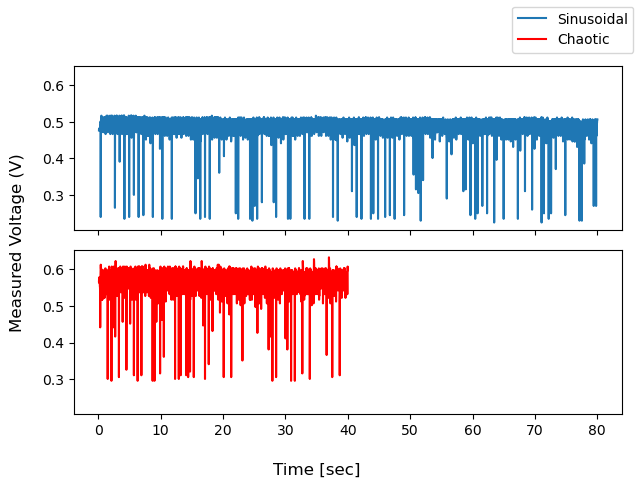

In [52]:
fig, axs = plt.subplots(2,1, sharex=True, sharey=True)
fig.supxlabel('Time [sec]')
fig.supylabel('Measured Voltage (V)')
axs[0].plot(np.arange(1,len(voltage8)+1)[10:]/100,voltage8[10:], label = 'Sinusoidal')
axs[1].plot(np.arange(1,len(numsChaotic)+1)[10:]/100,numsChaotic[10:], color = 'red', label = 'Chaotic')
fig.legend(loc=1)
fig.tight_layout(rect=[0, 0, 1, 0.9])

In [60]:
%store sinusoidal1
%store sinusoidal2
%store sinusoidal3
%store sinusoidal4
%store chaotic1
%store chaotic2
%store chaotic3
%store chaotic4
%store voltage4
%store voltage5
%store voltage8

Stored 'sinusoidal1' (ndarray)
Stored 'sinusoidal2' (ndarray)
Stored 'sinusoidal3' (ndarray)
Stored 'sinusoidal4' (ndarray)
Stored 'chaotic1' (ndarray)
Stored 'chaotic2' (ndarray)
Stored 'chaotic3' (ndarray)
Stored 'chaotic4' (ndarray)
Stored 'voltage4' (ndarray)
Stored 'voltage5' (ndarray)
Stored 'voltage8' (ndarray)


In [61]:
%store

Stored variables and their in-db values:
allData                 -> array([[-4.68  , -0.0832, -4.68  , ..., -0.0832, -
allData1                -> array([[-5.04  , -0.0744, -5.04  , ..., -0.1272, -
allTimes                -> array([[-0.3       , -0.3       , -0.3       , ...
allTimes1               -> array([[-0.3       , -0.3       , -0.3       , ...
chaotic1                -> array([0.506624, 0.506624, 0.5016  , ..., 0.5016  
chaotic2                -> array([1.099456, 0.506624, 0.5016  , ..., 0.496576
chaotic3                -> array([0.5016  , 0.5016  , 0.5016  , ..., 0.496576
chaotic4                -> array([3.174368, 0.491552, 0.5016  , ..., 0.496576
sinusoidal1             -> array([0.5016  , 0.491552, 0.5016  , ..., 0.5016  
sinusoidal2             -> array([1.089408, 0.496576, 0.496576, ..., 0.5016  
sinusoidal3             -> array([3.179392, 0.496576, 0.496576, ..., 0.506624
sinusoidal4             -> array([3.18944 , 0.506624, 0.506624, ..., 0.506624
voltage4               